# Интерполяция для задачи $1 | r_j | L_{max}$

In [2]:
import json
import time
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import clear_output
from scipy.interpolate import lagrange


In [1]:
timeout = 120
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale(self, alpha, key):
        if key == 'r':
            self.array[:,1] *= alpha
            self.array[:,2] *= alpha
        elif key == 'p':
            self.array[:,0] *= alpha
            self.array[:,2] *= alpha
        elif key == 'd':
            self.array[:,1] *= alpha
            self.array[:,0] *= alpha
        else:
            raise RuntimeError()
        return self
    
def dual(N, tau, B):
    if len(N.without(B)) == 0: return float('inf')
    pi_r = r(np.argsort(N, axis=0).transpose())
    bestL = N[pi_r].L(tau=tau)
    for i_k in pi_r:
        toDrop = B.copy()
        toDrop.append(i_k)
        #print(toDrop)
        s = N.without(toDrop)
        #print(s)
        if len(s) != 0:
            task_l = min(s, key=r)
            i_l = N.find(task_l)[0]
            pi_k = remove(pi_r, [i_l, i_k])
            pi_k = np.insert(pi_k, 0, i_l)
            pi_k = np.append(pi_k, i_k)
            L_k = N[pi_k].L(tau=tau)
            if L_k < bestL:
                bestL = L_k
    additionalL = N[pi_r].L(i=0, tau=tau)
    if additionalL > bestL:
        bestL = additionalL
    return bestL

class Instance:
    
    def __init__(self, N, tau=0, pi=[], B=[]):
        self.N = N.copy()
        self.tau = tau
        self.pi = pi.copy()
        self.B = B.copy()
        self.nu = dual(N, tau, B)
        
    def __getitem__(self, key):
        return TaskSet(self.N.array[key])
        
    def best_job(self):
        s = self.N.without(self.B)
        sn = s[r(s.transpose()) <= self.tau]
        if len(sn) == 0:
            f = min(s, key=r)
            #self.tau = r(f)
            #self.nu = dual(self.N, self.tau, self.B)
        else:
            f = min(sn, key=d)
        return self.N.find(f)[0]
    
    def L(self, i=None):
        return self[self.pi].L(i, self.tau)
    
    def T(self, i=None):
        return self[self.pi].T(i, self.tau)
        
    def L_max(self):
        return self[self.pi].L_max(self.tau)
    
    def T_max(self):
        return self[self.pi].T_max(self.tau)
    
    def __repr__(self):
        return "Instance:\n" + repr(self.N) + "\nnu  = " + str(self.nu) + "\ntau = " + str(self.tau) + "\npi  = " + str(self.pi) + "\nB   = " + str(self.B)
    
    
def main(N, tau=0, verbose=False, modified=False):
    tb = time.time()
    b_counter = 0
    #print("bi")
    instances = [Instance(N, tau)]
    #print("ai")
    if modified: bestPi = list(range(len(N)))
    else: bestPi = []
    while len(instances) > 0:
        ti = time.time()
        if ti - tb > timeout:
            return TaskSet([]), -1
        bestInstanceIndex, bestInstance = min(enumerate(instances), key=lambda x: x[1].nu) # + N[x[1].pi].L_max(tau))
        instances.pop(bestInstanceIndex)
        f = bestInstance.best_job()
        f_data = bestInstance[f]
        N1 = bestInstance.N.without(f)
        tau1 = max(r(f_data), bestInstance.tau) + p(f_data)
        B1 = []
        pi1 = bestInstance.pi.copy()
        pi1.append(N.find(f_data)[0])
        i1 = Instance(N1, tau1, pi1, B1)
        N2 = bestInstance.N
        tau2 = bestInstance.tau
        B2 = bestInstance.B.copy()
        B2.append(N2.find(f_data)[0]) #!
        pi2 = bestInstance.pi
        i2 = Instance(N2, tau2, pi2, B2)
        instances += [i1, i2]
        b_counter += 1
        #print(i1)
        if len(pi1) == len(N):
            #print(N[bestPi].L_max(tau))
            #print(pi1)
            if N[pi1].L_max(tau) < N[bestPi].L_max(tau):
                bestPi = pi1.copy()
                if verbose: print(bestPi, '\tLmax =', N[bestPi].L_max(tau))
        #lb = len(instances)
        instances = [i for i in instances if max(i.nu, N[i.pi].L_max(tau)) < N[bestPi].L_max(tau)]
        #print(lb, len(instances))
    return bestPi, b_counter
        

## Генерация простых примеров
**Критерий:** время выполнения алгоритма не более секунды

In [52]:
N_TASKS = 100
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
s_array = []
while len(s_array) < N_TASKS:
    s = TaskSet(10)
    res, count = main(s.copy().scale(0, 'r'))
    if count != -1:
        s_array.append(s)
        pBar.value += 1

IntProgress(value=0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


```python
with open("easy100Schedules.json", 'w') as f:
    json.dump(list(map(lambda x: x.array.tolist(), s_array)), f)
```

In [3]:
def parse_tasks(n_tasks=100):
    with open("easy100Schedules.json", 'r') as f:
        s_array = json.load(f)
    return [TaskSet(s) for s in s_array[:n_tasks]]

In [4]:
schedules = parse_tasks()

In [5]:
alphaRange = np.arange(0, 2.1, 0.1)

In [6]:
def linear_equation(x, x1, x2):
    return (x - x1) / (x2 - x1)

In [9]:
def test_linear(key):
    res = 0
    prgBar = IntProgress(min = 0, max = len(schedules))
    display(prgBar)
    for n, s in enumerate(schedules):
        scaledSchedules = []
        #s = TaskSet(10)
        for alpha in alphaRange:
            #print(s.copy().scale(alpha, key=key))
            scaledSchedules.append(s.copy().scale(alpha, key=key))
        flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))

        pointResults = []
        s1, s2 = flattenedScaledSchedules[:2]
        for s in flattenedScaledSchedules[2:]:
            linearEqResults = []
            for index, x1 in enumerate(s1):
                x2 = s2[index]
                x = s[index]
                if x2 != x1: linearEqResults.append(linear_equation(x, x1, x2))
            pointResults.append(np.all(np.isclose(linearEqResults, linearEqResults[0])))
        if np.all(pointResults): res += 1
        prgBar.value += 1
    print("Все точки на одной прямой в %s %% примеров" % (100*res/len(schedules)))

# Всегда ли точки лежат на одной прямой?
(Теор. док-во высылал в формате ТеХ)

In [10]:
test_linear('r')

IntProgress(value=0)

Все точки на одной прямой в 100.0 % примеров


In [11]:
test_linear('p')

IntProgress(value=0)

Все точки на одной прямой в 100.0 % примеров


In [12]:
test_linear('d')

IntProgress(value=0)

Все точки на одной прямой в 100.0 % примеров


# Интерполяция Лагранжа

In [13]:
#alphaRange = remove(np.arange(0, 2, 0.1), 1.)
#alphaRange = np.arange(0, 2.1, 0.1)
def lagrange_interpolation(key):
    N_TASKS = 10

    prgBar = IntProgress(min = 0, max = len(alphaRange))
    display(prgBar)
    for n in range(N_TASKS):
        s = schedules[n]
        prgBar.value = 0
        scaledSchedules = []
        for alpha in alphaRange:
            scaledSchedules.append(s.copy().scale(alpha, key=key))
        flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))

        #print("\rCurrently working with", n)
        approxResults = []
        if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
        for i, a in enumerate(alphaRange):
            s = scaledSchedules[i]
            Lmax = s[main(s, verbose=False)[0]].L_max()
            prgBar.value = prgBar.value + 1
            approxResults.append((a, Lmax))
        approxResults = np.array(approxResults)
        trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0]
        if trueIndex: 
            trueIndex = trueIndex[0]
            trueValue = approxResults[trueIndex]
            approxResults = np.delete(approxResults, trueIndex, axis=0)
        x = approxResults[:,0]
        y = approxResults[:,1]
        #print(x, y)
        poly = lagrange(x, y)
        xp = np.arange(x[0], x[-1], 0.01)
        yp = poly(xp)
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
        fig.suptitle("Расписание для %s примера" % n)
        axes.scatter(x, y, label="Experimental data")
        axes.plot(xp, yp, label="Interpolation")
        axes.grid()
        axes.set_xlabel("Коэффициент а")
        axes.set_ylabel("Значение целевой функции")
        axes.plot(1., trueValue[1], 'ro', label="True value", alpha=0.5)
        axes.legend()

# $r'_j = \alpha r_j$

IntProgress(value=0, max=21)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


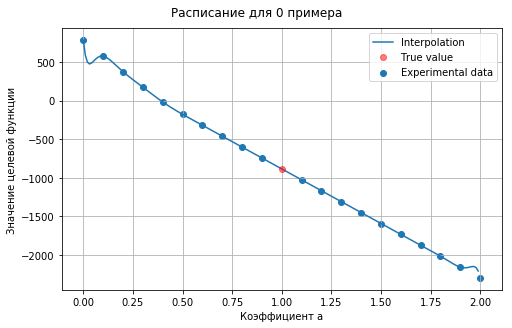

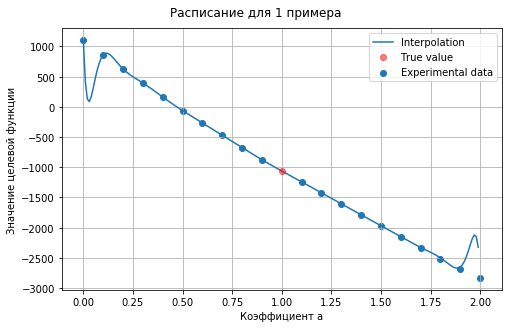

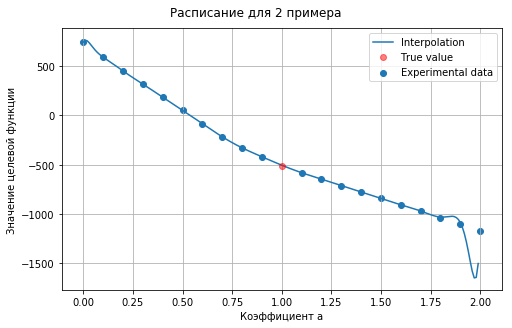

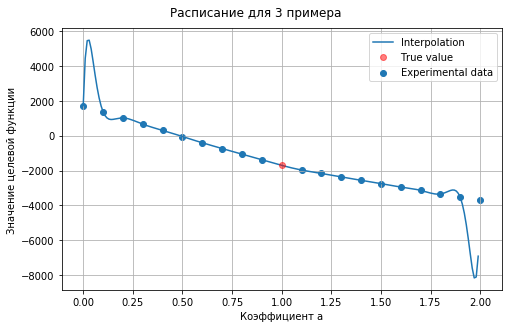

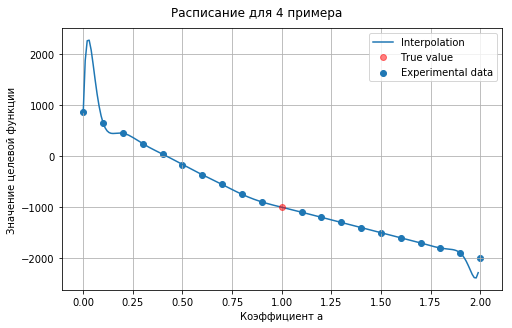

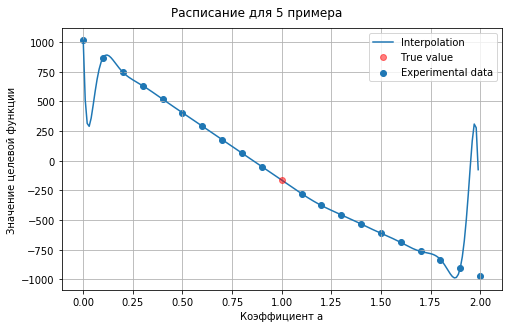

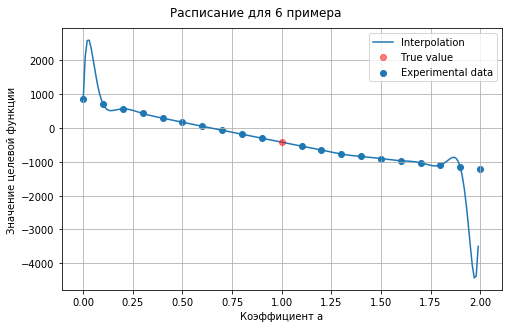

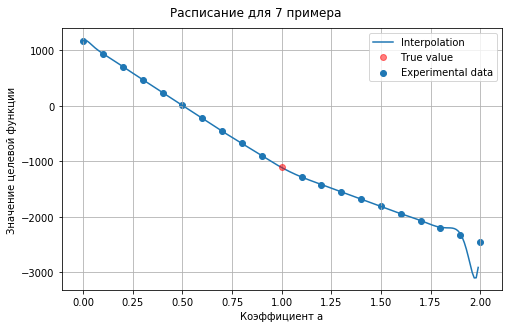

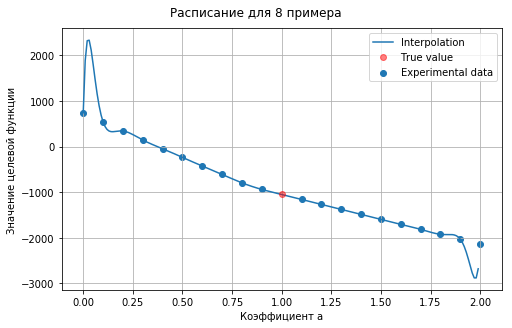

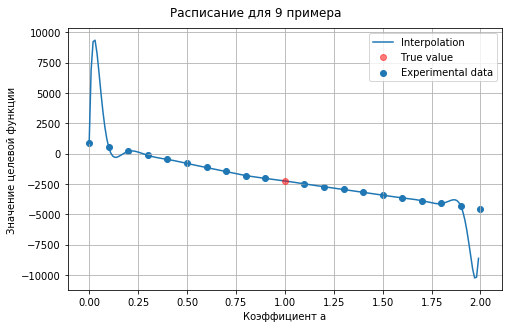

In [14]:
lagrange_interpolation('r')

# $p'_j = \alpha p_j$

IntProgress(value=0, max=21)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


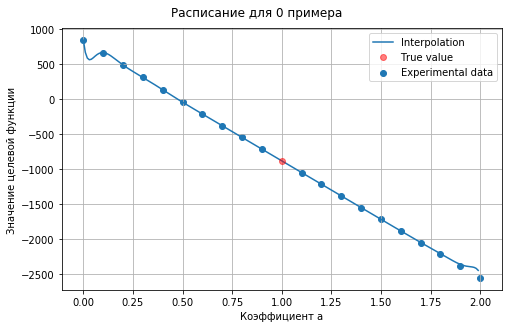

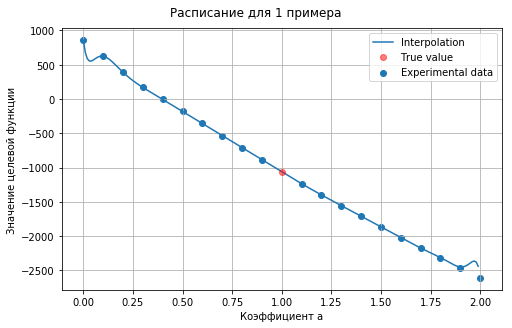

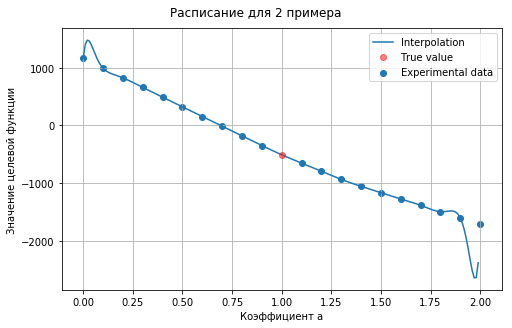

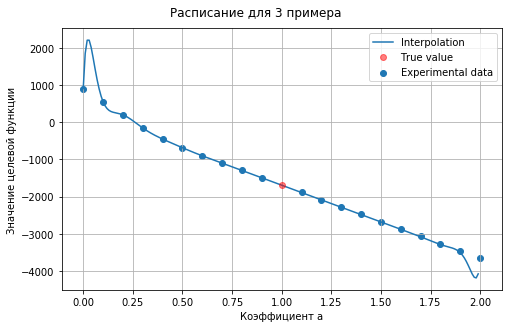

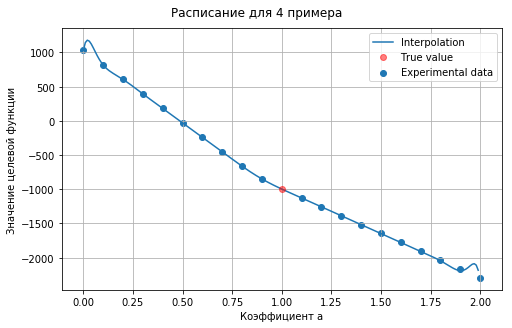

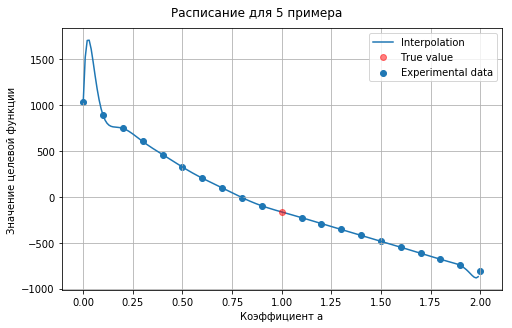

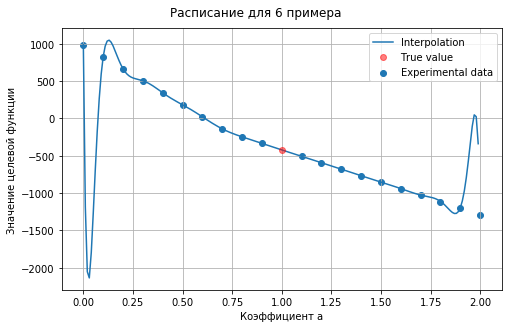

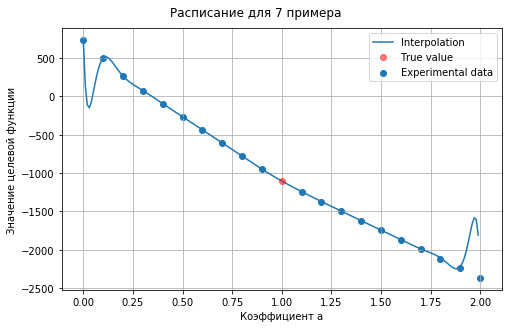

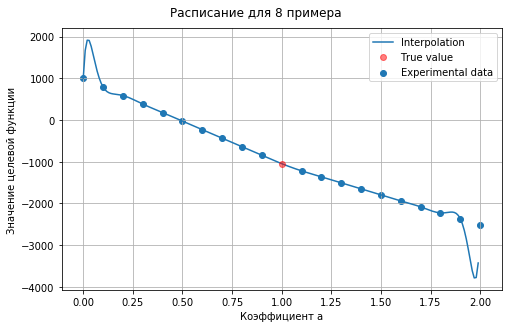

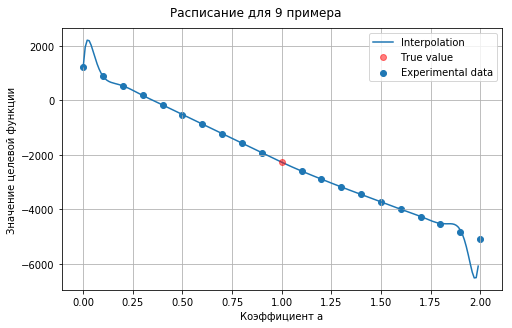

In [15]:
lagrange_interpolation('p')

# $d'_j = \alpha d_j$

IntProgress(value=0, max=21)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


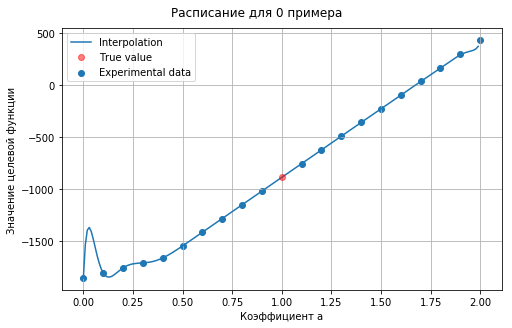

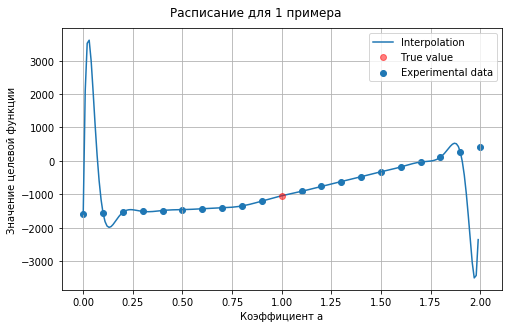

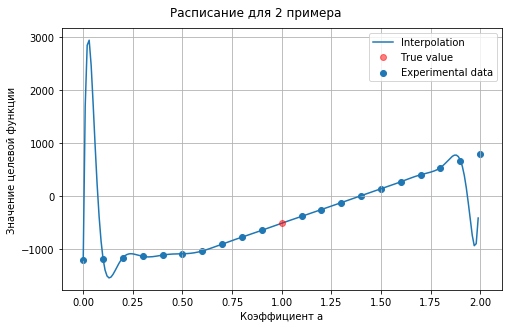

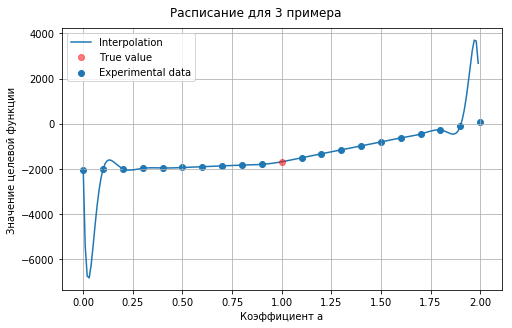

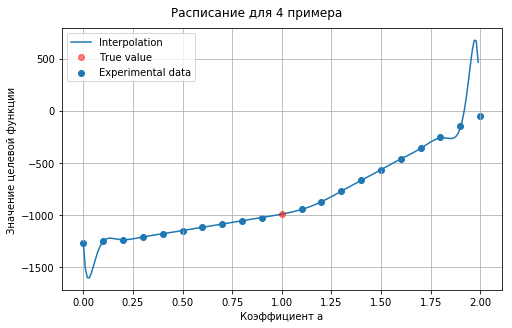

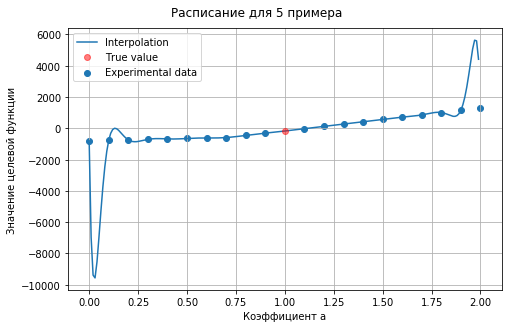

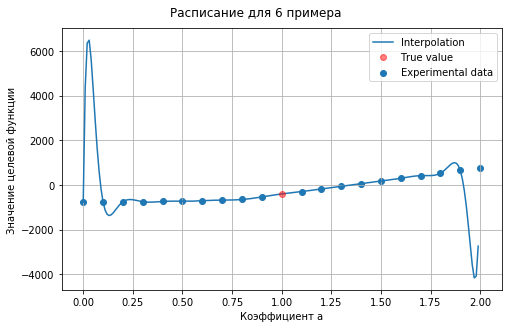

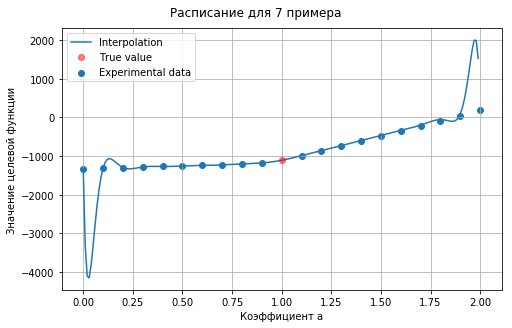

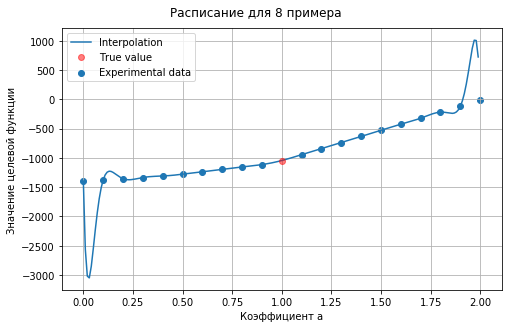

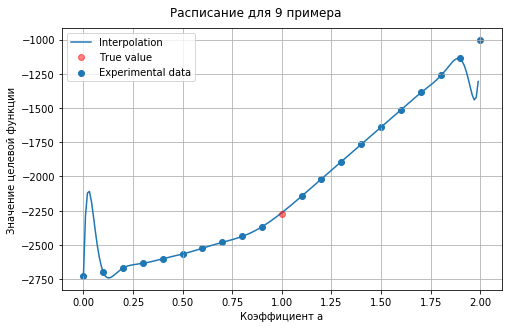

In [16]:
lagrange_interpolation('d')

# Интерполяция Чебышёва

In [17]:
def interpolate_chebyshev(k, n_tasks=10):
    global realResult
    global approxResults
    global m
    global s
    global key
    key = k

    def test_schedule(alpha_arr):
        global key
        global approxResults
        global realResult
        global m
        global s
        approxResults = []
        for a in alpha_arr:
            #print("\ra =", a, end='')
            scaled_s = s.copy().scale(a, key=key)
            #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
            bestPi, bestCounter = main(scaled_s, verbose=False)
            Lmax = scaled_s[bestPi].L_max()
            approxResults.append((a, Lmax))
        bestPi, bestCounter = main(s, verbose=False)
        Lmax = s[bestPi].L_max()
        realResult = (1., Lmax)
        approxResults = np.array(approxResults)
        return approxResults[:,1]

    pBar = IntProgress(min=0, max=n_tasks)
    display(pBar)
    for i, s in enumerate(schedules[:n_tasks]):
        C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
        approxResults = np.array(approxResults)

        x = approxResults[:,0]
        y = approxResults[:,1]
        xp = np.arange(0, 2, 0.001)
        yp = C(xp)

        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
        fig.suptitle("Расписание для %s примера" % i)
        axes.scatter(x, y, label="Experimental data")
        axes.plot(xp, yp, label="Interpolation")
        axes.grid()
        axes.set_xlabel("Коэффициент а")
        axes.set_ylabel("Значение целевой функции")
        axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
        axes.legend()
        pBar.value += 1

# $r'_j = \alpha r_j$

IntProgress(value=0, max=10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


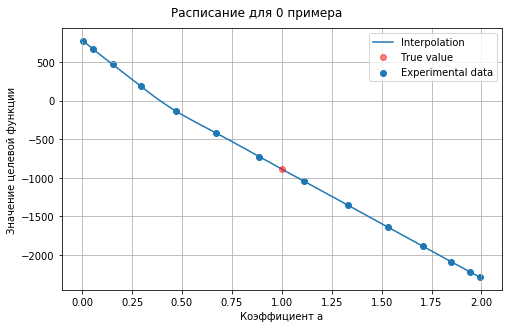

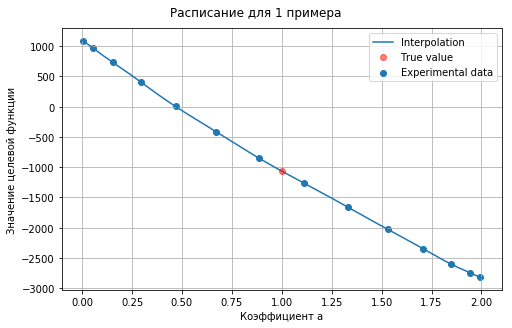

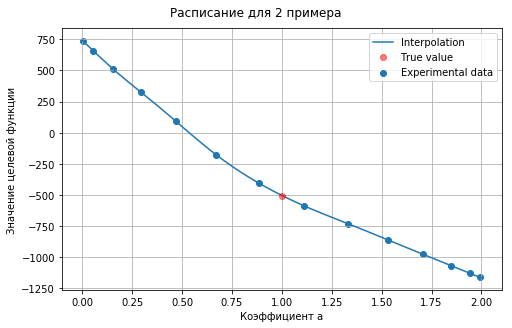

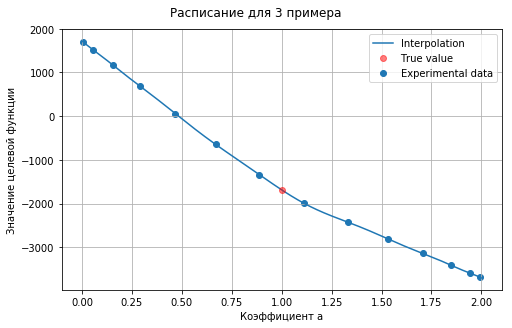

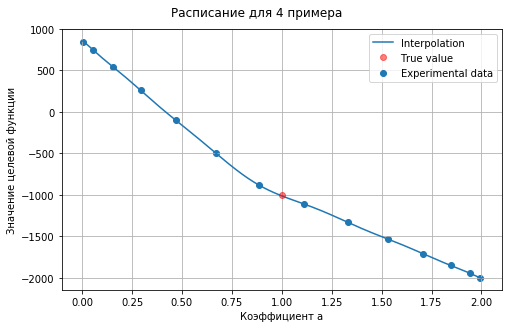

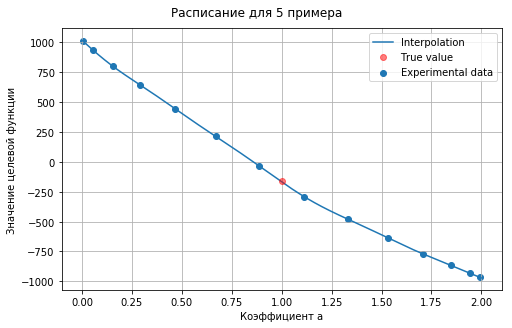

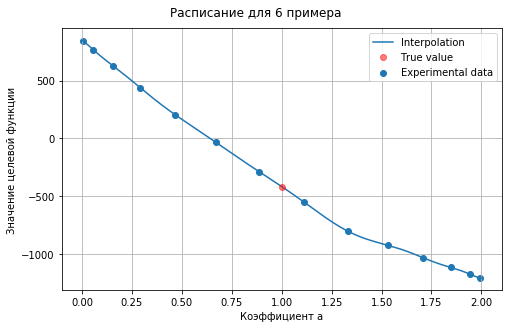

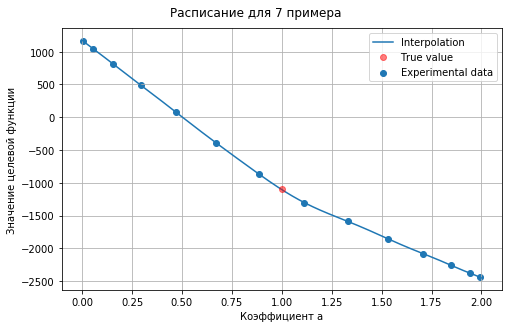

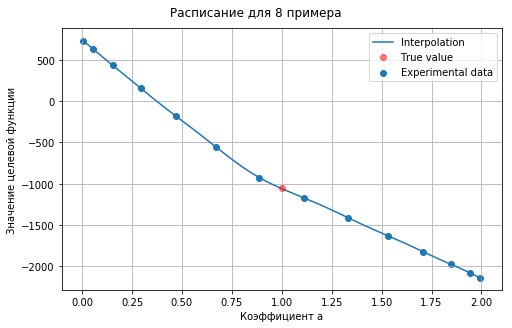

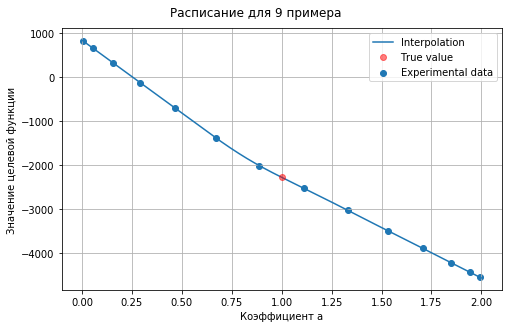

In [18]:
interpolate_chebyshev('r')

# $p'_j = \alpha p_j$

IntProgress(value=0, max=10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


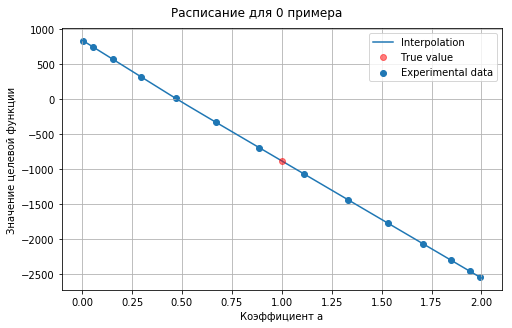

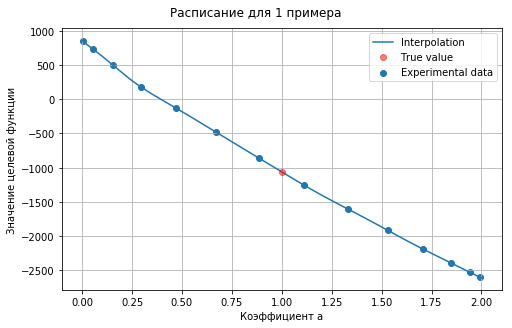

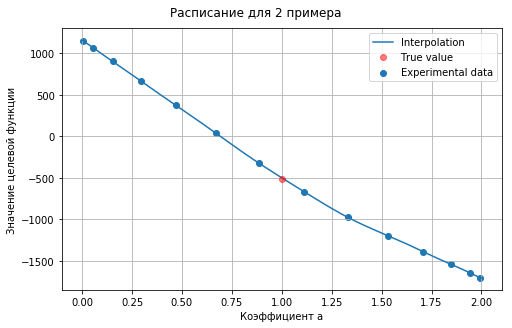

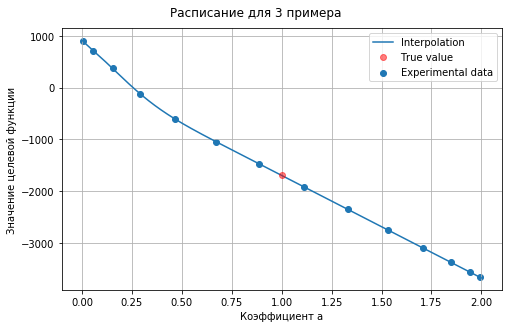

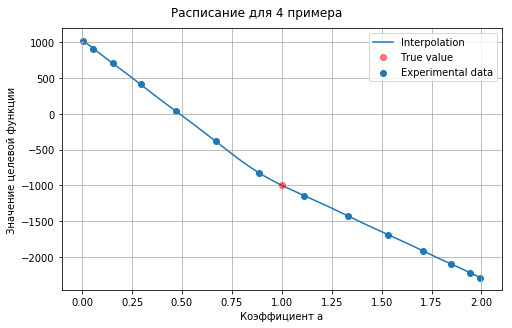

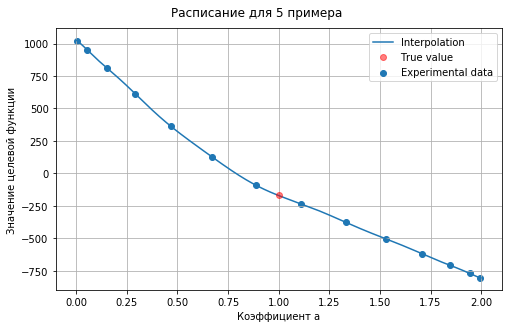

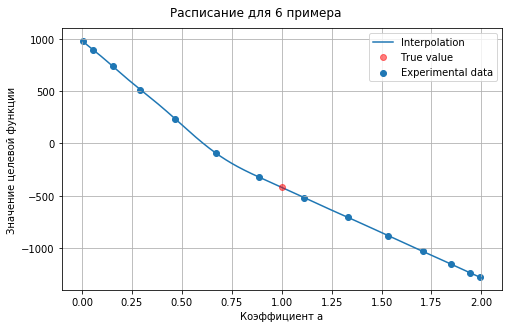

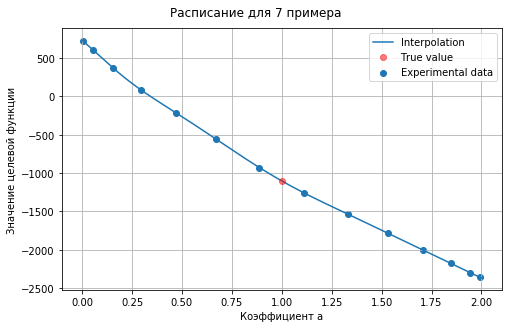

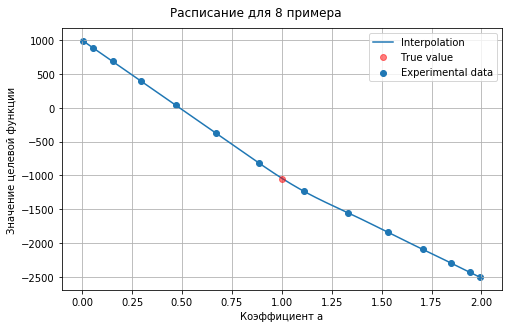

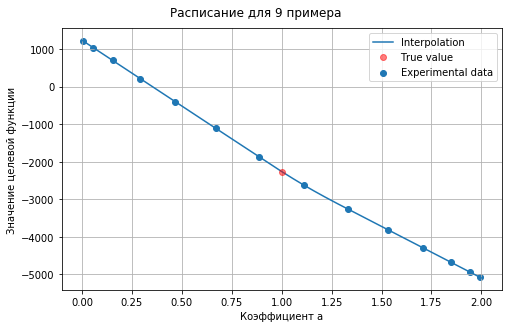

In [19]:
interpolate_chebyshev('p')

# $d'_j = \alpha d_j$

IntProgress(value=0, max=10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


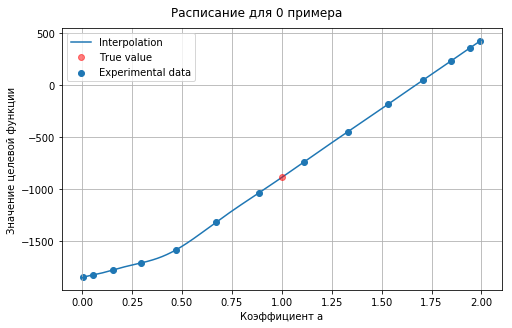

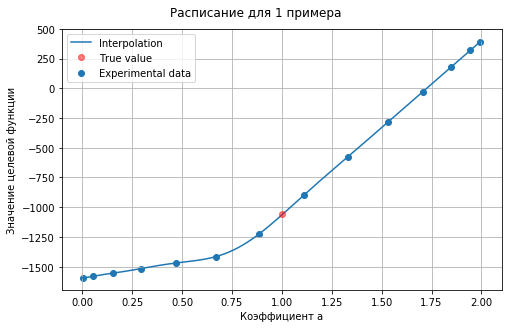

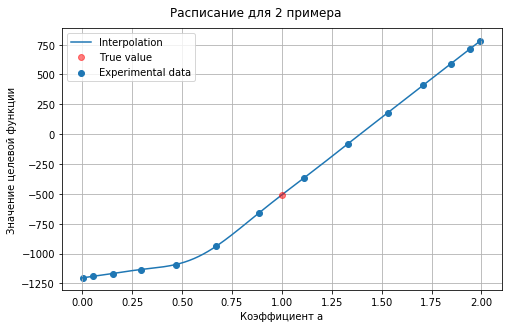

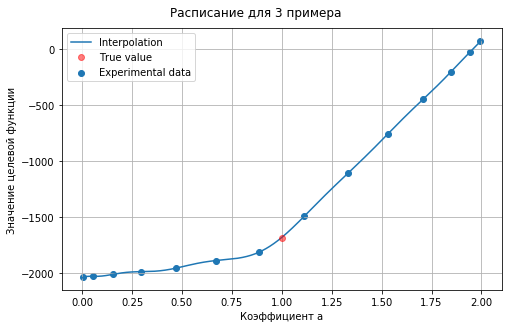

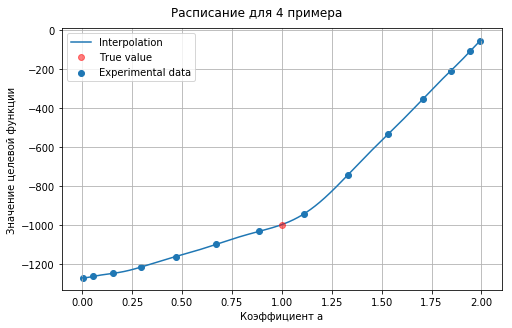

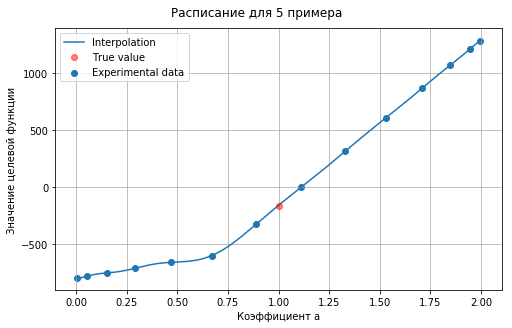

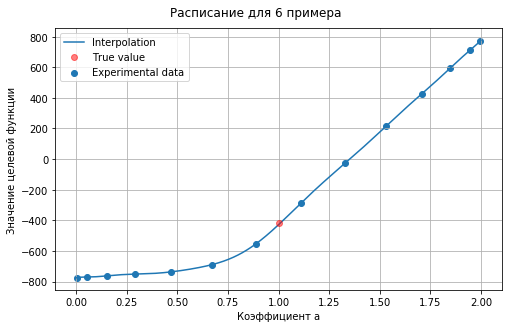

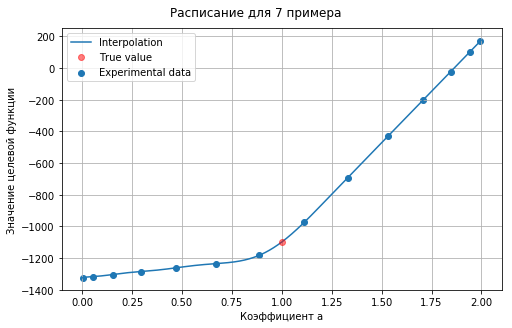

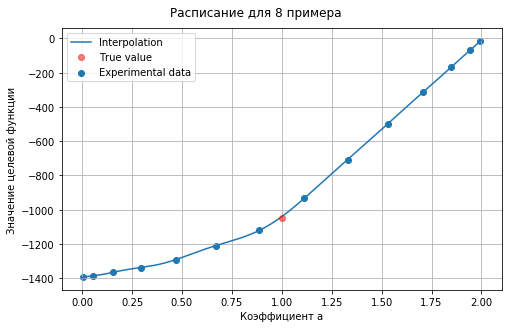

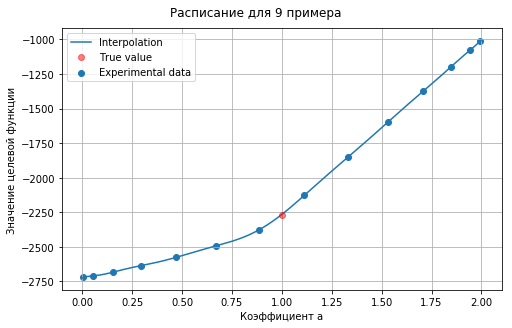

In [20]:
interpolate_chebyshev('d')

In [21]:
def error_estimate_chebyshev(k, n_tasks=100, method='relative'):
    global realResult
    global approxResults
    global m
    global s
    global key
    key = k

    def test_schedule(alpha_arr):
        global key
        global approxResults
        global realResult
        global m
        global s
        approxResults = []
        for a in alpha_arr:
            #print("\ra =", a, end='')
            scaled_s = s.copy().scale(a, key=key)
            #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
            bestPi, bestCounter = main(scaled_s, verbose=False)
            Lmax = scaled_s[bestPi].L_max()
            approxResults.append((a, Lmax))
        bestPi, bestCounter = main(s, verbose=False)
        Lmax = s[bestPi].L_max()
        realResult = (1., Lmax)
        approxResults = np.array(approxResults)
        return approxResults[:,1]

    pBar = IntProgress(min=0, max=n_tasks)
    display(pBar)
    x = []
    y = []
    for n in range(3, 11):
        pBar.value = 0
        results = []
        for i, sched in enumerate(schedules[:n_tasks]):
            s = sched[:n]
            C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
            if method == 'relative':
                results.append((C(1.) - realResult[1])/realResult[1]*100)
            elif method == 'absolute':
                results.append(C(1.) - realResult[1])
            else: raise RuntimeError()
            pBar.value += 1
        x.append(n)
        y.append(np.mean(np.abs(results)))
    return x, y

# Оценка ошибки интерполяции

# Интерполяция Лагранжа

In [22]:
def error_estimate_lagrange(key, n_tasks, method='relative'):
    res_x, res_y = [], []
    prgBar = IntProgress(min = 0, max = len(alphaRange))
    display(prgBar)
    for s_size in range(3, 11):
        prgBar.value = 0
        results = []
        for n in range(n_tasks):
            s = schedules[n][:s_size]
            prgBar.value = 0
            scaledSchedules = []
            for alpha in alphaRange:
                scaledSchedules.append(s.copy().scale(alpha, key=key))
            flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))

            #print("\rCurrently working with", n)
            approxResults = []
            if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
            for i, a in enumerate(alphaRange):
                s = scaledSchedules[i]
                Lmax = s[main(s, verbose=False)[0]].L_max()
                prgBar.value = prgBar.value + 1
                approxResults.append((a, Lmax))
            approxResults = np.array(approxResults)
            trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0]
            if trueIndex: 
                trueIndex = trueIndex[0]
                trueValue = approxResults[trueIndex]
                approxResults = np.delete(approxResults, trueIndex, axis=0)
            else: raise RuntimeError()
            x = approxResults[:,0]
            y = approxResults[:,1]
            #print(x, y)
            poly = lagrange(x, y)
            if method == 'relative':
                results.append((poly(1.) - trueValue[1])/trueValue[1]*100)
            elif method == 'absolute':
                results.append(poly(1.) - trueValue[1])
            else:
                raise RuntimeError()
        res_x.append(s_size)
        res_y.append(np.mean(np.abs(results)))
    return res_x, res_y

# $r'_j = \alpha r_j$

IntProgress(value=0, max=21)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Text(0, 0.5, 'Средний модуль ошибки интерполяции, %')

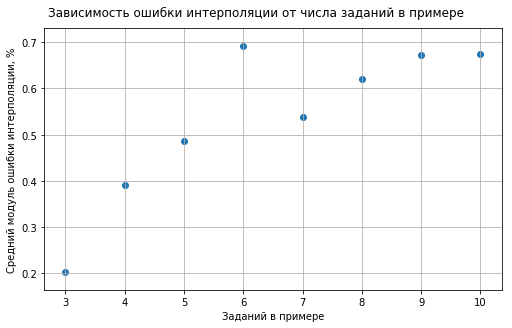

In [23]:
x, y = error_estimate_lagrange('r', n_tasks=20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от числа заданий в примере")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Заданий в примере")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()

# $p'_j = \alpha p_j$

IntProgress(value=0, max=21)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Text(0, 0.5, 'Средний модуль ошибки интерполяции, %')

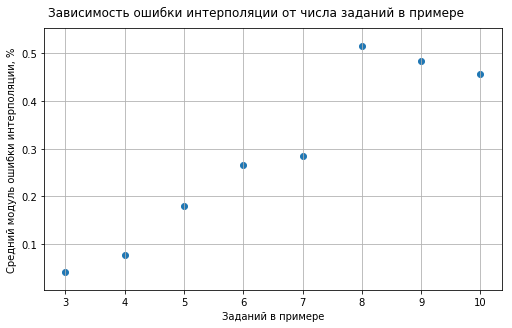

In [24]:
x, y = error_estimate_lagrange('p', n_tasks=20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от числа заданий в примере")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Заданий в примере")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()

# $d'_j = \alpha d_j$

IntProgress(value=0, max=21)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Text(0, 0.5, 'Средний модуль ошибки интерполяции, %')

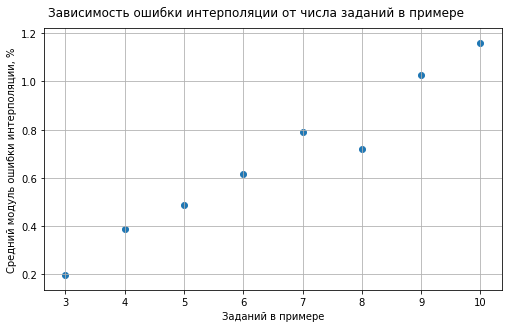

In [25]:
x, y = error_estimate_lagrange('d', n_tasks=20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от числа заданий в примере")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Заданий в примере")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()

# Интерполяция Чебышева

# $r'_j = \alpha r_j$

IntProgress(value=0, max=20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Text(0, 0.5, 'Средний модуль ошибки интерполяции, %')

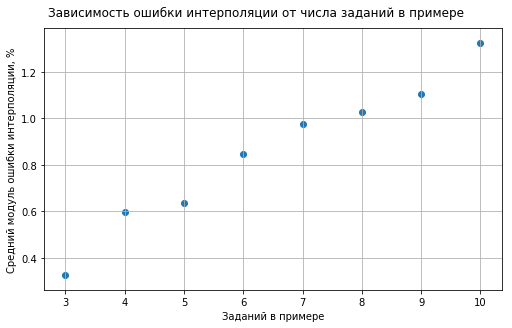

In [26]:
x, y = error_estimate_chebyshev('r', n_tasks=20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от числа заданий в примере")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Заданий в примере")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()

# $p'_j = \alpha p_j$

IntProgress(value=0, max=20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Text(0, 0.5, 'Средний модуль ошибки интерполяции, %')

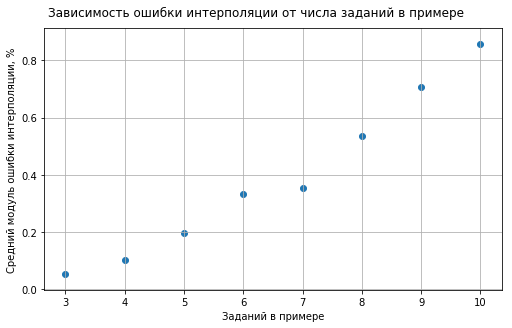

In [27]:
x, y = error_estimate_chebyshev('p', n_tasks=20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от числа заданий в примере")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Заданий в примере")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()

# $d'_j = \alpha d_j$

IntProgress(value=0, max=20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Text(0, 0.5, 'Средний модуль ошибки интерполяции, %')

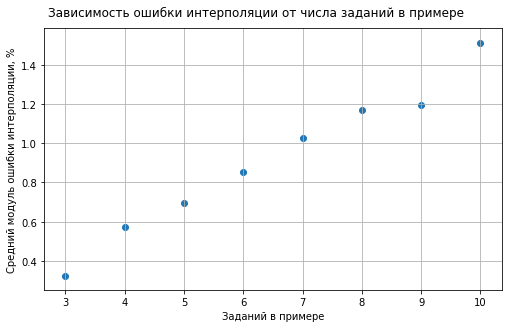

In [28]:
x, y = error_estimate_chebyshev('d', n_tasks=20)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от числа заданий в примере")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Заданий в примере")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()

# Итоги и выводы
- Для преобразований величин r, p, d проверено нахождение точек на одной прямой
- Интерполяцией Чебышёва и Лагранжа аппроксимированы значения $L_{max}$ для примеров с преобразованными величинами r, p, d
- Построены графики зависимостей ошибки интерполяции от кол-ва работ в примере для всех трёх преобразований и обоих методов интерполяции
- Опровергнута гипотеза о взаимной ортогональности сложных примеров (теор. опровержение отправлю отдельно)
- Реализован поиск сложных примеров с помощью градиентного спуска